In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings
import random
import os
warnings.filterwarnings(action="ignore")

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# output csv에 시간 지정해주기 위함
from datetime import datetime

import sys
sys.path.append("../")
from feature_engineering import *

# 시간이 오래 걸리는 부분들에 대한 연산 시간 구하기 위함
import time

# 태훈님의 dataloader.py import해서 preprocessing
from dataloader import *

In [2]:
def to_categories(df):
    # 카테고리형 feature
# 여기에 범주형 feature들 이름을 추가해주세요!
    categories = [
                "userID",
                "KnowledgeTag",
                "first3", 
                "year",
                "month", 
                "day",
                "hour",
                "minute",
                "second",
                "timeConcentrationCount",
                "timeConcentrationLevel",
                "monthSolvedCount"
                ]
    # 카테고리형 feature들에 label encoding 수행하는 작업
    le = preprocessing.LabelEncoder()
    for category in categories:
        if category in df.columns and df[category].dtypes != "int":
            df[category] = le.fit_transform(df[category])
        df[category] = df[category].astype("category")
    return df

In [3]:
# 데이터 준비
train_data, test_data = load_data(IS_CUSTOM=False)
data = get_entire_data(train_data, test_data)
data = get_features(data)
data = to_categories(data)

In [4]:
train, valid, test = split_train_valid_test_categorical(data)

In [5]:
FEATS = [
        "userID",
        # "answerCode",
        # "KnowledgeTag",
        "userAnswerRate",
        "userSolvedLen",
        "testAnswerRate",
        "testSolvedLen",
        "testAnswerSum",
        "tagAnswerRate",
        "tagSolvedLen",
        "tagAnswerSum",
        "year",
        "month",
        "day",
        "hour",
        "minute",
        "second",
        "first3",
        "timeConcentrationRate",
        "timeConcentrationCount",
        "timeConcentrationLevel",
        "user_correct_answer",
        "user_total_answer",
        "user_acc",
        "monthAnswerRate",
        "monthSolvedCount",
        ]

In [6]:
X_train = train.drop(["answerCode"], axis=1)
y_train = train["answerCode"]

X_valid = valid.drop(["answerCode"], axis=1)
y_valid = valid["answerCode"]

In [7]:
X_valid

,userID,KnowledgeTag,userAnswerRate,userSolvedLen,testAnswerRate,testSolvedLen,testAnswerSum,tagAnswerRate,tagSolvedLen,tagAnswerSum,...,second,first3,timeConcentrationRate,timeConcentrationCount,timeConcentrationLevel,user_correct_answer,user_total_answer,user_acc,monthAnswerRate,monthSolvedCount
2724,3,5289,0.693705,826,0.654592,1960,1283,0.560101,3178,1780,...,11,4,0.704725,73020,2,574.0,824,0.696602,0.66861,360086
3395,4,9080,0.691505,671,0.642736,1184,761,0.540971,2514,1360,...,31,6,0.641730,172663,1,464.0,669,0.693572,0.49315,69999
10561,13,9660,0.694002,1317,0.454819,1992,906,0.490897,2966,1456,...,1,6,0.633326,163186,1,914.0,1315,0.695057,0.49315,69999
14854,17,2611,0.817460,1260,0.437075,588,257,0.414663,832,345,...,22,8,0.624247,179235,0,1030.0,1258,0.818760,0.66861,360086
23097,26,1422,0.748011,377,0.640212,1701,1089,0.609375,4672,2847,...,1,5,0.709353,164041,2,283.0,375,0.754667,0.66861,360086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475943,7395,2102,0.250000,24,0.789933,1490,1177,0.746814,2354,1758,...,18,3,0.641730,172663,1,7.0,22,0.318182,0.67006,370592
2476086,7404,7636,0.400000,15,0.865753,1460,1264,0.824793,4703,3879,...,31,2,0.681932,154574,2,6.0,13,0.461538,0.66861,360086
2476287,7416,10402,0.400000,15,0.744856,972,724,0.820255,3288,2697,...,17,4,0.641730,172663,1,7.0,13,0.538462,0.66861,360086
2476302,7417,10402,0.066667,15,0.744856,972,724,0.820255,3288,2697,...,54,4,0.704725,73020,2,2.0,13,0.153846,0.67006,370592


In [8]:
n_est = 2000
seed = 42
n_fold = 10

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

folds=[]
for train_idx, valid_idx in skfold.split(X_train, y_train):
    folds.append((train_idx, valid_idx))

In [9]:
cat_models = []

cat_features = X_train[FEATS].columns[X_train[FEATS].dtypes == "category"].to_list()
cat_features

['userID',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'first3',
 'timeConcentrationCount',
 'timeConcentrationLevel',
 'monthSolvedCount']

In [10]:
"""
fold = False하면 k-fold를 사용하지 않습니다.
전체 데이터셋을 학습하고 싶으면 아래에 normal = False를 normal = True로 변경해주시면 됩니다.
fold = True를 하면 cat_models에 model이 저장됩니다. 
"""
fold = True
if fold:
    for fold in range(n_fold):
        print(f"\n----------------- Fold {fold} -----------------\n")
        start_time = time.time()

        # CatBoostRegressor 사용
        params = {
            "iterations": 150,
            "learning_rate": 0.1,  # 0.1
            "eval_metric": "AUC",
            "random_seed": 42,
            # "logging_level": "Verbose", # 매 epoch마다 로그를 찍고 싶으면 "logging_level": "Verbose"로 변경
            "early_stopping_rounds": 100,
            "task_type": "GPU",
            "depth":12,
            "verbose":100
        }
        
        model = CatBoostRegressor(
            **params,
            cat_features=cat_features,
            allow_writing_files=False,
        )
        
        train_idx, valid_idx = folds[fold]
        X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = X_train[FEATS].iloc[train_idx], X_train[FEATS].iloc[valid_idx], y_train.iloc[train_idx], y_train.iloc[valid_idx]

        train_data = Pool(data=X_train_fold, label=y_train_fold, cat_features=cat_features)
        valid_data = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=cat_features)

        model.fit(
            train_data,
            eval_set=valid_data,
            # plot=True, # plot 찍고 싶으면 주석 제거
            use_best_model=True,
        )

        # 여기서 AUC 계산에 사용되는 X_valid는 X_valid_fold랑 다름. 
        # 최종 성능 평가는 더 위에서 생성한 X_valid라는 별도의 고정된 데이터로 한다고 생각하면 됩니다.
        cat_models.append(model)
        preds = model.predict(X_valid[FEATS])
        acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
        auc = roc_auc_score(y_valid, preds)

        print(f"VALID AUC : {auc} ACC : {acc}\n")

        print(f"elapsed: {time.time() - start_time: .3f}")


----------------- Fold 0 -----------------

0:	learn: 0.7317067	test: 0.7304287	best: 0.7304287 (0)	total: 291ms	remaining: 43.4s
100:	learn: 0.7614436	test: 0.7563007	best: 0.7563007 (100)	total: 28s	remaining: 13.6s
149:	learn: 0.7682241	test: 0.7606012	best: 0.7606012 (149)	total: 41.3s	remaining: 0us
bestTest = 0.7606011579
bestIteration = 149
VALID AUC : 0.7489374775974194 ACC : 0.6841397849462365

elapsed:  52.987

----------------- Fold 1 -----------------

0:	learn: 0.7315598	test: 0.7338646	best: 0.7338646 (0)	total: 264ms	remaining: 39.3s
100:	learn: 0.7616837	test: 0.7598696	best: 0.7598696 (100)	total: 28.6s	remaining: 13.9s
149:	learn: 0.7687432	test: 0.7640443	best: 0.7640443 (149)	total: 42.2s	remaining: 0us
bestTest = 0.7640443225
bestIteration = 149
VALID AUC : 0.7472111072909885 ACC : 0.6774193548387096

elapsed:  52.787

----------------- Fold 2 -----------------

0:	learn: 0.7320936	test: 0.7305607	best: 0.7305607 (0)	total: 261ms	remaining: 38.9s
100:	learn: 0.761

KeyboardInterrupt: 

In [11]:
"""
여기서는 전체 데이터셋을 학습하고 싶을 때 normal = Ture로 설정하면
model에 전체 데이터셋을 학습한 모델이 저장됩니다.

참고: kfold는 cat_models라는 list에 fold별로 모델들이 별도로 저장되서 신경 안써도 됩니다.
"""
normal = False
# 일반 성능: VALID AUC : 0.7499030745484736 ACC : 0.6841397849462365
if normal:
    start_time = time.time()

    # CatBoostRegressor 사용
    params = {
        "iterations": 150,
        "learning_rate": 0.1,  # 0.1
        "eval_metric": "AUC",
        "random_seed": 42,
        "logging_level": "Silent", # 매 epoch마다 로그를 찍고 싶으면 "logging_level": "Verbose"로 변경
        "early_stopping_rounds": 100,
        "task_type": "GPU",
        "depth":12
    }

    model = CatBoostRegressor(
        **params,
        cat_features=cat_features,
        allow_writing_files=False,
    )

    model.fit(
        train[FEATS],
        y_train,
        eval_set=[(valid[FEATS], y_valid)],
        # plot=True, # plot 찍고 싶으면 주석 제거
    )

    preds = model.predict(valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    print(f"VALID AUC : {auc} ACC : {acc}\n")

    print(f"elapsed: {time.time() - start_time: .3f}")

In [12]:
# valid AUC, valid ACC, fold AUC 모두 고려해서 best를 저장해주세요
best_fold_idx = 1
model = cat_models[best_fold_idx]

elapsed:  5.337 sec


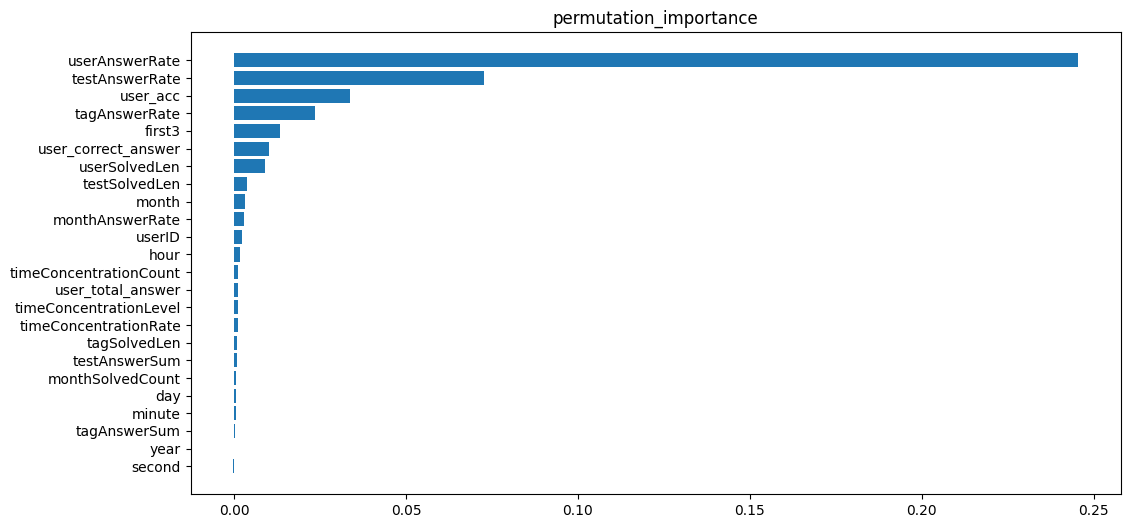

In [13]:
start_time = time.time()

result = permutation_importance(model, X_valid[FEATS], y_valid, scoring = "roc_auc", n_repeats=30, random_state=42)
sorted_result = result.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(FEATS)), result.importances_mean[sorted_result], align="center")
plt.yticks(range(len(FEATS)), np.array(FEATS)[sorted_result])
plt.title("permutation_importance")

print(f"elapsed: {time.time() - start_time: .3f} sec")

elapsed:  0.060 sec


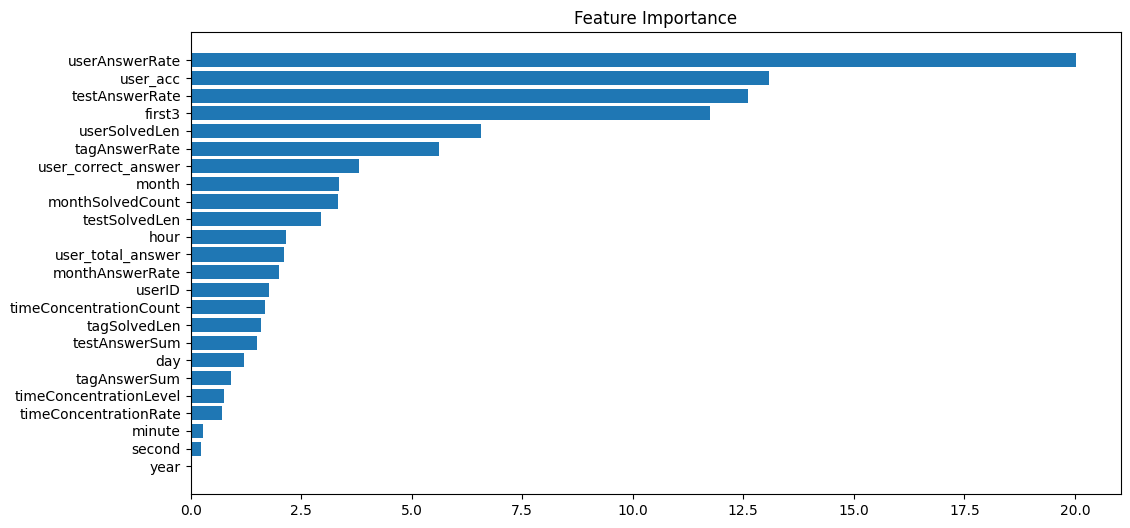

In [14]:
start_time = time.time()

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(FEATS)[sorted_idx])
plt.title("Feature Importance")

print(f"elapsed: {time.time() - start_time: .3f} sec")

In [15]:
start_time = time.time()

X_test = test.drop(["answerCode"], axis=1)
total_preds = model.predict(X_test[FEATS])

print(f"elapsed: {time.time() - start_time: .3f} sec")

elapsed:  0.010 sec


In [16]:
# SAVE OUTPUT
output_dir = "/opt/ml/input/CatBoost_output"
write_path = os.path.join(output_dir, f"CatBoost_submission_{datetime.now().microsecond}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : /opt/ml/input/CatBoost_output/CatBoost_submission_633665.csv
